In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def criar_grafo_orientacao(caminho_arquivo):
    try:
        # Carregar o arquivo CSV
        # Carregar os dados do arquivo CSV, especificando a codificação
        df = pd.read_csv(caminho_arquivo, sep=';', encoding='latin-1')

        # Selecionar apenas as colunas relevantes e remover linhas com dados faltantes
        colunas_necessarias = ['DiscenteID', 'OrientadorID', 'Unidade', 'Codigo_Projeto']
        df_limpo = df[colunas_necessarias].dropna()

        # Criando uma chave única para cada combinação de DiscenteID, OrientadorID e Codigo_Projeto
        df_limpo['chave_unica'] = df_limpo['DiscenteID'].astype(str) + '_' + df_limpo['OrientadorID'].astype(str) + '_' + df_limpo['Codigo_Projeto'].astype(str)

        # Remover duplicatas com base nesta chave única
        df_processado = df_limpo.drop_duplicates(subset=['chave_unica']).copy()

        # Cria listas de identificadores únicos com prefixos, para evitar conflitos de nomes de nós no grafo
        discentes = ['discente_' + str(i) for i in df_processado['DiscenteID'].unique()]
        orientadores = ['orientador_' + str(i) for i in df_processado['OrientadorID'].unique()]
        departamentos = ['departamento_' + str(i) for i in df_processado['Unidade'].unique()]

        # Criando grafo
        G = nx.Graph()
        G.add_nodes_from(discentes, bipartite='discente')
        G.add_nodes_from(orientadores, bipartite='orientador')
        G.add_nodes_from(departamentos, bipartite='departamento')

        # Adicionando arestas com prefixos
        for _, row in df_processado.iterrows():
            G.add_edge(
                'discente_' + str(row['DiscenteID']),
                'orientador_' + str(row['OrientadorID']),
                tipo='orientacao'
            )

        # Arestas orientador <-> departamento
        pesos = df_processado.groupby(['OrientadorID', 'Unidade']).size().reset_index(name='peso')
        for _, row in pesos.iterrows():
            G.add_edge(
                'orientador_' + str(row['OrientadorID']),
                'departamento_' + str(row['Unidade']),
                peso=row['peso'],
                tipo='afiliacao'
            )

        # Imprimir informações sobre o grafo
        print(f"Número total de nós: {G.number_of_nodes()}")
        print(f"Número total de arestas: {G.number_of_edges()}")
        print(f"A densidade do grafo: {nx.density(G)}")
        print(f"Assortatividade do grafo: {nx.degree_assortativity_coefficient(G)}")
        return G # Retornar o grafo corrigido

    except FileNotFoundError:
        print(f"Erro: O arquivo '{caminho_arquivo}' não foi encontrado. Verifique o nome e o caminho do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

# Exemplo de como usar a função com o seu arquivo
caminho_do_seu_arquivo = "./Iniciação_Ciêntifica - Dados Abertos.csv"
grafo_final = criar_grafo_orientacao(caminho_do_seu_arquivo)

Número total de nós: 28219
Número total de arestas: 33618
A densidade do grafo: 8.443723820245974e-05
Assortatividade do grafo: -0.23886269027776913


✅ Dataset carregado com sucesso para filtragem correta
🏛️ DEPARTAMENTOS DISPONÍVEIS:
 1: ESCOLA DE MÚSICA - EMUFRN
 2: DEPARTAMENTO DE ENGENHARIA QUIMICA - DEQ/CT
 3: CENTRO DE CIÊNCIAS SOCIAIS APLICADAS - CCSA
 4: DEPARTAMENTO DE CIÊNCIAS ADMINISTRATIVAS - DEPAD - DEPAD/CCSA
 5: DEPARTAMENTO DE ENGENHARIA DE COMUNICAÇÕES - DCO/CT
 6: CENTRO DE CIÊNCIAS EXATAS E DA TERRA - CCET
 7: DEPARTAMENTO DE ESTATISTICA - EST/CCET
 8: ESCOLA AGRÍCOLA DE JUNDIAÍ - EAJ
 9: DEPARTAMENTO DE DIREITO PUBLICO - DIPUB - DPU/CCSA
10: DEPARTAMENTO DE FONOAUDIOLOGIA - DEPFONO
11: DEPARTAMENTO DE SAÚDE COLETIVA - DSC/CCS
12: CERES - DEPARTAMENTO DE GEOGRAFIA - DGC/CERES
13: DEPARTAMENTO DE SERVIÇO SOCIAL - DESSO - DESSO/CCSA
14: DEPARTAMENTO DE FUNDAMENTOS E POLÍTICAS DA EDUCAÇÃO - DFPE/CE
15: DEPARTAMENTO DE CIRURGIA - DCIRUR/CCS
16: DEPARTAMENTO DE ANÁLISES CLÍNICAS E TOXICOLÓGICAS - DACT/CCS
17: ESCOLA DE CIÊNCIAS E TECNOLOGIA - ECT
18: DEPARTAMENTO DE PSICOLOGIA - PSIC/CCHLA
19: DEPARTAMENTO DE COMUNICAÇ

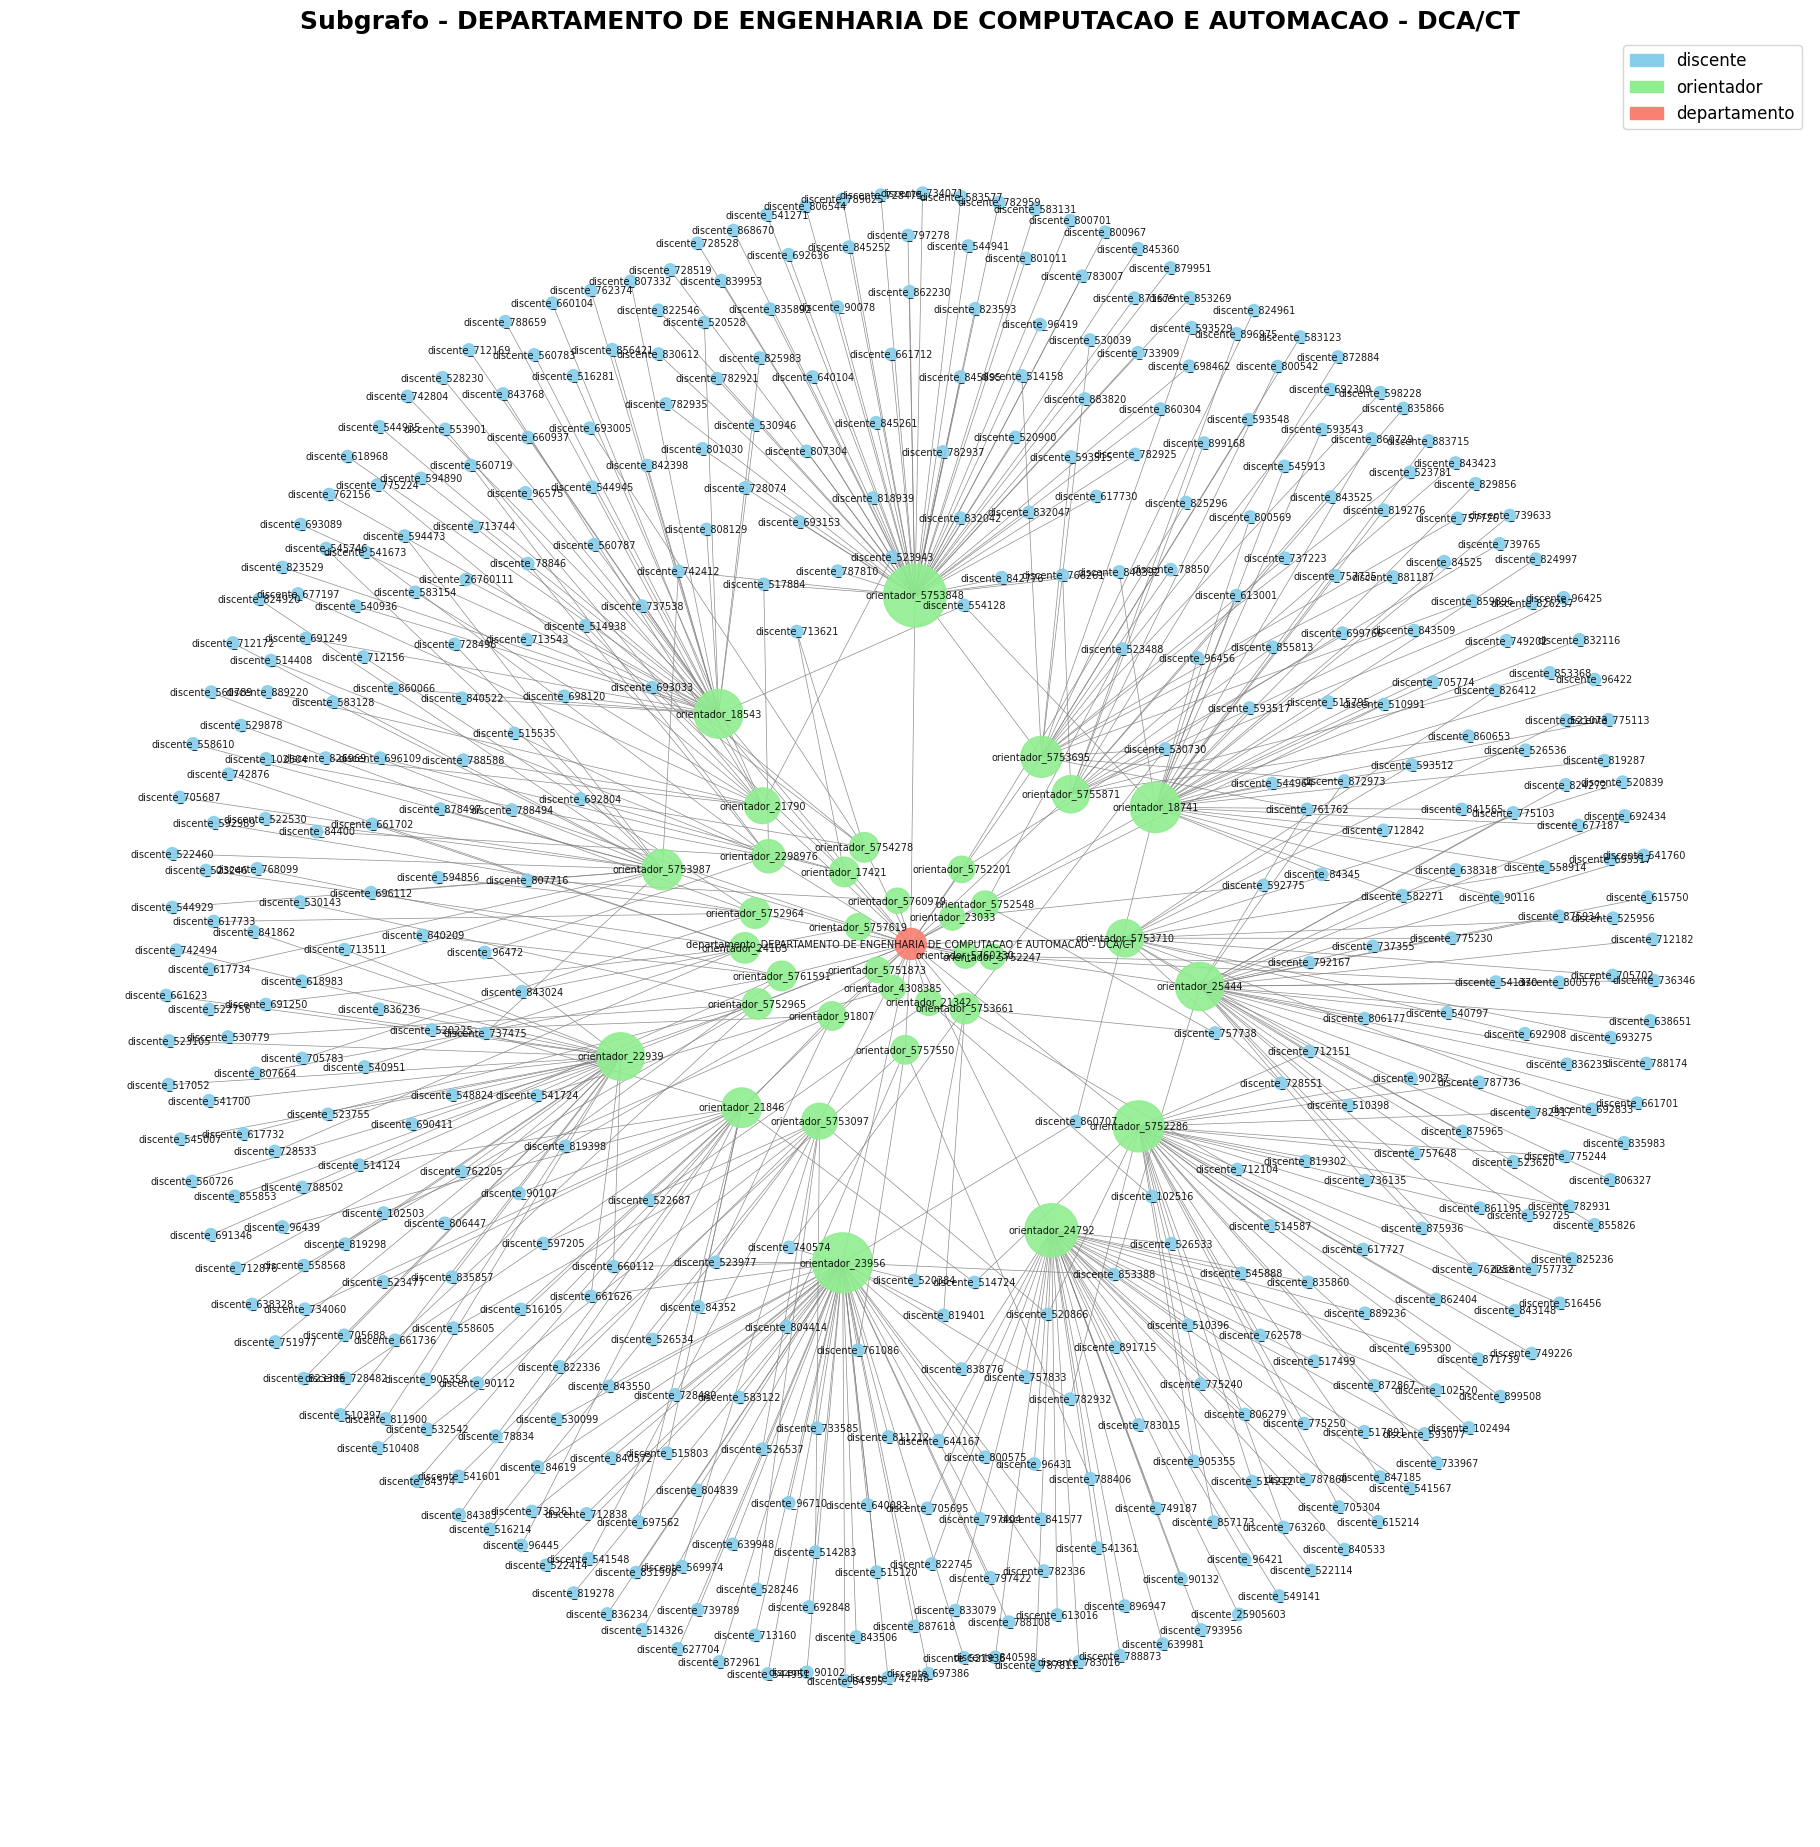

In [33]:
from matplotlib.patches import Patch

# Filtragem por departamento

# Carregar novamente o dataset para fazer a filtragem correta
try:
    df_original = pd.read_csv("./Iniciação_Ciêntifica - Dados Abertos.csv", sep=';', encoding='latin-1')
    print("✅ Dataset carregado com sucesso para filtragem correta")
except Exception as e:
    print(f"❌ Erro ao carregar dataset: {e}")
    df_original = None

# Obter a lista de departamentos do grafo
departamentos_grafo = [node for node, data in grafo_final.nodes(data=True) if data.get('bipartite') == 'departamento']

# Permitir que o usuário escolha o departamento de interesse
print("🏛️ DEPARTAMENTOS DISPONÍVEIS:")
print("="*60)
for i, dep in enumerate(departamentos_grafo):
    dept_name = dep.replace("departamento_", "")
    print(f"{i+1:2d}: {dept_name}")

escolha = input(f"\n📋 Digite o número do departamento (1 a {len(departamentos_grafo)}): ")

try:
    indice_escolhido = int(escolha) - 1
    if 0 <= indice_escolhido < len(departamentos_grafo):
        departamento_interesse = departamentos_grafo[indice_escolhido]
        dept_name = departamento_interesse.replace("departamento_", "")
        print(f"✅ Departamento selecionado: {dept_name}")
    else:
        departamento_interesse = None
        print("❌ Escolha inválida.")
except ValueError:
    departamento_interesse = None
    print("❌ Entrada inválida.")

# Filtrar o subgrafo 
if departamento_interesse and df_original is not None:
    # Extrair o nome do departamento sem o prefixo
    nome_departamento_real = departamento_interesse.replace("departamento_", "")
    
    # 🔧 Filtrar APENAS registros do departamento selecionado
    df_departamento = df_original[df_original['Unidade'] == nome_departamento_real].copy()
    
    if df_departamento.empty:
        print(f"❌ Nenhum registro encontrado para o departamento: {nome_departamento_real}")
    else:
        # Obter IDs únicos que realmente pertencem ao departamento
        discentes_dept_ids = df_departamento['DiscenteID'].unique()
        orientadores_dept_ids = df_departamento['OrientadorID'].unique()
        
        # Converter para formato do grafo (com prefixos)
        discentes_dept_nodes = set(['discente_' + str(id_) for id_ in discentes_dept_ids])
        orientadores_dept_nodes = set(['orientador_' + str(id_) for id_ in orientadores_dept_ids])
        
        # Filtrar apenas os nós que existem no grafo
        discentes_validos = discentes_dept_nodes & set(grafo_final.nodes())
        orientadores_validos = orientadores_dept_nodes & set(grafo_final.nodes())
        
        # Criar lista de nós para o subgrafo (apenas do departamento)
        nodes_subgrafo = [departamento_interesse] + list(orientadores_validos) + list(discentes_validos)
        
        # Gerar o subgrafo 
        subgrafo_departamento = grafo_final.subgraph(nodes_subgrafo).copy()
        
        # 📊 ESTATÍSTICAS DO SUBGRAFO
        print(f"🔗 Total de nós no subgrafo: {subgrafo_departamento.number_of_nodes()}")
        print(f"🌐 Total de arestas: {subgrafo_departamento.number_of_edges()}")
        print(f"📈 Densidade do subgrafo: {nx.density(subgrafo_departamento):.4f}")
        
        if subgrafo_departamento.number_of_nodes() > 1:
            print(f"🔄 Assortatividade: {nx.degree_assortativity_coefficient(subgrafo_departamento):.4f}")
        
        # Calcular discentes por orientador no subgrafo corrigido
        discentes_por_orientador = {}
        for orientador in orientadores_validos:
            if orientador in subgrafo_departamento.nodes():
                count = 0
                for vizinho in subgrafo_departamento.neighbors(orientador):
                    if subgrafo_departamento.nodes[vizinho].get('bipartite') == 'discente':
                        count += 1
                discentes_por_orientador[orientador] = count

        # VISUALIZAÇÃO DO SUBGRAFO 
        cores_mapa = {
            'discente': 'skyblue',
            'orientador': 'lightgreen',
            'departamento': 'salmon'
        }

        # Definir tamanhos dos nós
        tamanhos_nos = []
        for node in subgrafo_departamento.nodes():
            if subgrafo_departamento.nodes[node].get('bipartite') == 'orientador':
                tamanho = 300 + (discentes_por_orientador.get(node, 0) * 30)
                tamanhos_nos.append(tamanho)
            elif subgrafo_departamento.nodes[node].get('bipartite') == 'discente':
                tamanhos_nos.append(80)
            else:
                tamanhos_nos.append(500)

        # Mapear cores
        node_colors = [cores_mapa.get(subgrafo_departamento.nodes[node].get('bipartite'), 'gray') 
                      for node in subgrafo_departamento.nodes()]

        # Aqui podemos brincar um pouco com diferentes layouts! Teste agora mesmo!"
        # pos = nx.spring_layout(subgrafo_departamento, k= 1) # Ajuste o parâmetro k para espaçamento
        pos = nx.kamada_kawai_layout(subgrafo_departamento)
        # pos = nx.random_layout(subgrafo_departamento) # Um layout aleatório para começar
        #pos = nx.circular_layout(subgrafo_departamento)

        # Criar visualização
        plt.figure(figsize=(18, 18))
        nx.draw(subgrafo_departamento, pos, 
                node_color=node_colors, 
                node_size=tamanhos_nos,
                with_labels=True, 
                font_size=7, 
                alpha=0.9, 
                edge_color='gray', 
                width=0.5)

        # Legenda
        legend_patches = [Patch(color=color, label=label) for label, color in cores_mapa.items()]
        plt.legend(handles=legend_patches, loc='best', fontsize=12)

        # Título 
        plt.title(f"Subgrafo - {nome_departamento_real}", 
                 fontsize=18, fontweight='bold')
        plt.axis('off')
        plt.show()
        
else:
    print("❌ Não foi possível gerar o subgrafo. Verifique se o departamento foi selecionado e o dataset foi carregado.")

In [30]:
import plotly.graph_objects as go
import numpy as np

# VISUALIZAÇÃO 3D ACHATADA (1 NÍVEL) - USANDO O SUBGRAFO DA CÉLULA 2
# Esta célula usa os dados já processados na célula 2

# Verificar se o subgrafo foi criado na célula anterior
try:
    # Verificar se as variáveis necessárias existem
    if 'subgrafo_departamento' in locals() and 'departamento_interesse' in locals():
        print("✅ Usando subgrafo da célula 2")
    else:
        print("❌ Subgrafo não encontrado. Execute a célula 2 primeiro!")
        subgrafo_departamento = None
        departamento_interesse = None
except:
    print("❌ Erro ao acessar dados da célula 2. Execute a célula 2 primeiro!")
    subgrafo_departamento = None
    departamento_interesse = None

# Prosseguir apenas se o subgrafo existir
if subgrafo_departamento is not None and departamento_interesse is not None:
    # Recalcular orientadores e discentes para a visualização 3D
    orientadores_departamento = set()
    discentes_orientados = set()
    
    for node, data in subgrafo_departamento.nodes(data=True):
        if data.get('bipartite') == 'orientador':
            orientadores_departamento.add(node)
        elif data.get('bipartite') == 'discente':
            discentes_orientados.add(node)
    
    # Recalcular discentes por orientador
    discentes_por_orientador = {}
    for discente in discentes_orientados:
        for vizinho in subgrafo_departamento.neighbors(discente):
            if subgrafo_departamento.nodes[vizinho].get('bipartite') == 'orientador':
                discentes_por_orientador[vizinho] = discentes_por_orientador.get(vizinho, 0) + 1


    # Visualizar o subgrafo filtrado e Adicionar rótulos e legendas
    # Definir as cores para cada tipo de nó
    cores_mapa = {
        'discente': 'skyblue',
        'orientador': 'lightgreen',
        'departamento': 'salmon'
    }

    # Definir tamanhos dos nós
    tamanhos_nos = []
    for node in subgrafo_departamento.nodes():
        if subgrafo_departamento.nodes[node].get('bipartite') == 'orientador':
            # Aumentar o tamanho do nó do orientador com base no número de discentes
            tamanho = 300 + (discentes_por_orientador.get(node, 0) * 30)
            tamanhos_nos.append(tamanho)
        elif subgrafo_departamento.nodes[node].get('bipartite') == 'discente':
            tamanhos_nos.append(80) # Tamanho ligeiramente maior para discentes
        else:
            tamanhos_nos.append(500) # Tamanho maior para o departamento

    # VISUALIZAÇÃO 3D COM APENAS 1 NÍVEL (ACHATADA)
    
    # Criar layout com APENAS 1 NÍVEL (todos os nós no mesmo Z)
    pos_3d = {}
    
    # Usar layout 2D, mas com Z = 0 para TODOS os nós
    pos_2d_flat = nx.spring_layout(subgrafo_departamento, k=1.2, iterations=150)
    
    for node in subgrafo_departamento.nodes():
        x, y = pos_2d_flat[node]
        # TODOS os nós no mesmo nível (Z = 0)
        pos_3d[node] = (x, y, 0.0)
    
    # Preparar dados para as arestas (conexões) - versão achatada
    edge_x = []
    edge_y = []
    edge_z = []
    
    for edge in subgrafo_departamento.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x.extend([x0, x1, None])  # None para separar as linhas
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
    
    # Criar traço das arestas para visualização achatada
    edge_trace = go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        line=dict(width=1.5, color='rgba(125,125,125,0.4)'),
        hoverinfo='none',
        mode='lines',
        name='Conexões'
    )
    
    # Preparar dados dos nós por tipo - versão achatada
    traces = [edge_trace]
    
    # Cores Plotly para cada tipo de nó
    cores_plotly = {
        'discente': 'lightblue',
        'orientador': 'lightgreen', 
        'departamento': 'salmon'
    }
    
    for node_type, cor in cores_plotly.items():
        # Filtrar nós do tipo atual
        nodes_of_type = [node for node in subgrafo_departamento.nodes() 
                        if subgrafo_departamento.nodes[node].get('bipartite') == node_type]
        
        if nodes_of_type:
            # Coordenadas achatadas (todos em Z = 0)
            x_coords = [pos_3d[node][0] for node in nodes_of_type]
            y_coords = [pos_3d[node][1] for node in nodes_of_type]
            z_coords = [pos_3d[node][2] for node in nodes_of_type]  # Todos = 0
            
            # Preparar texto de hover e tamanhos
            hover_texts = []
            sizes = []
            
            for node in nodes_of_type:
                if node_type == 'departamento':
                    hover_text = f"Departamento: {node.replace('departamento_', '')}"
                    size = 20
                elif node_type == 'orientador':
                    num_orientandos = discentes_por_orientador.get(node, 0)
                    hover_text = f"Orientador: {node.replace('orientador_', '')}<br>Orientandos: {num_orientandos}"
                    size = 12 + (num_orientandos * 1.5)
                else:  # discente
                    hover_text = f"Discente: {node.replace('discente_', '')}"
                    size = 6
                
                hover_texts.append(hover_text)
                sizes.append(size)
            
            # Criar traço para versão achatada
            node_trace = go.Scatter3d(
                x=x_coords, y=y_coords, z=z_coords,
                mode='markers',
                marker=dict(
                    size=sizes,
                    color=cor,
                    line=dict(width=1, color='DarkSlateGrey'),
                    opacity=0.7
                ),
                text=hover_texts,
                hoverinfo='text',
                name=f'{node_type.capitalize()}'
            )
            traces.append(node_trace)
    
    # Layout para visualização achatada (1 nível)
    nome_departamento = departamento_interesse.replace("departamento_", "")
    
    layout = go.Layout(
        title=dict(
            text=f'Subgrafo 3D Achatado (1 Nível) - {nome_departamento}',
            x=0.5,
            font=dict(size=18)
        ),
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[
            dict(
                text="🔴 Departamento | 🟢 Orientadores | 🔵 Discentes",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002,
                xanchor='left', yanchor='bottom',
                font=dict(size=12)
            )
        ],
        scene=dict(
            xaxis=dict(
                title='Coordenada X',
                backgroundcolor="rgb(240, 240, 240)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white"
            ),
            yaxis=dict(
                title='Coordenada Y', 
                backgroundcolor="rgb(240, 240, 240)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white"
            ),
            zaxis=dict(
                title='Nível Hierárquico (ACHATADO)',
                backgroundcolor="rgb(240, 240, 240)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white",
                range=[-0.5, 0.5],  # Range muito pequeno para mostrar o "achatamento"
                tickvals=[0],
                ticktext=['Todos os Nós']
            ),
            camera=dict(
                eye=dict(x=0, y=0, z=2.5)  # Vista de cima para mostrar o achatamento
            )
        )
    )
    
    # Criar e exibir a figura achatada
    fig = go.Figure(data=traces, layout=layout)
    
    # Configurar renderer para compatibilidade
    import plotly.io as pio
    pio.renderers.default = "notebook"
    
    try:
        fig.show()
    except Exception as e:
        print(f"Erro ao exibir gráfico interativo: {e}")
        print("Tentando salvar como HTML estático...")
        fig.write_html("subgrafo_3d_achatado.html")
        print("Gráfico salvo como 'subgrafo_3d_achatado.html'")
        print("Abra o arquivo HTML no navegador para visualização interativa.")
    
else:
    print("Não foi possível gerar o subgrafo pois o departamento não foi selecionado ou é inválido.")

✅ Usando subgrafo da célula 2


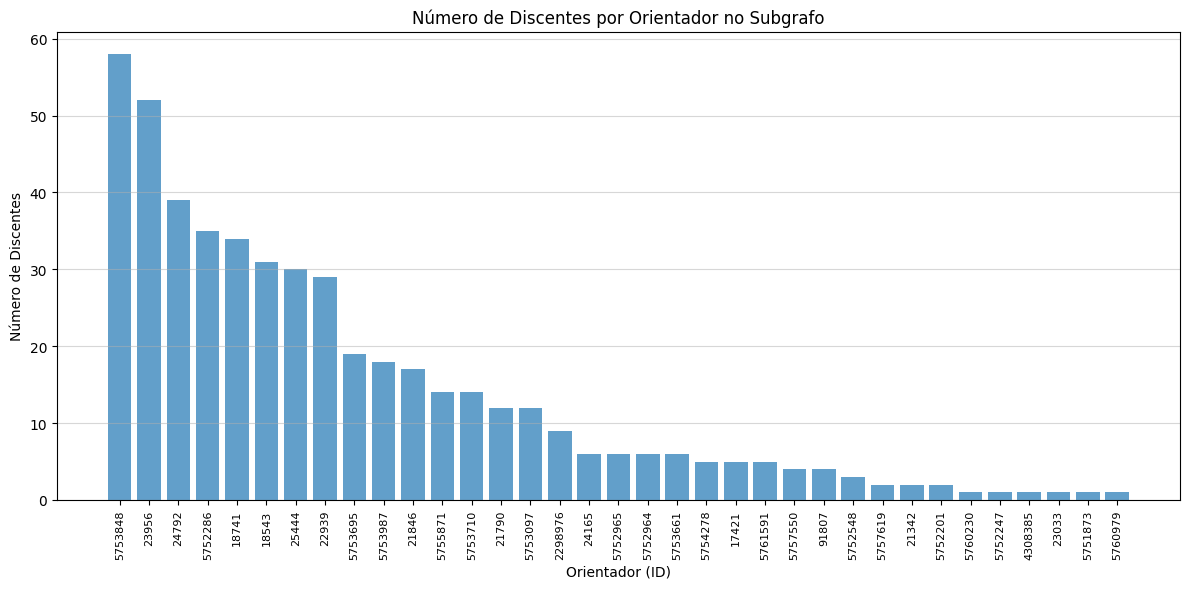


=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES (SUBGRAFO) ===
Total de Discentes: 452
Grau médio dos discentes: 1.07
Grau mínimo: 1
Grau máximo: 2

=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES (SUBGRAFO) ===
Total de professores: 35
Número médio de orientandos: 13.86
Mínimo de orientandos: 1
Máximo de orientandos: 58


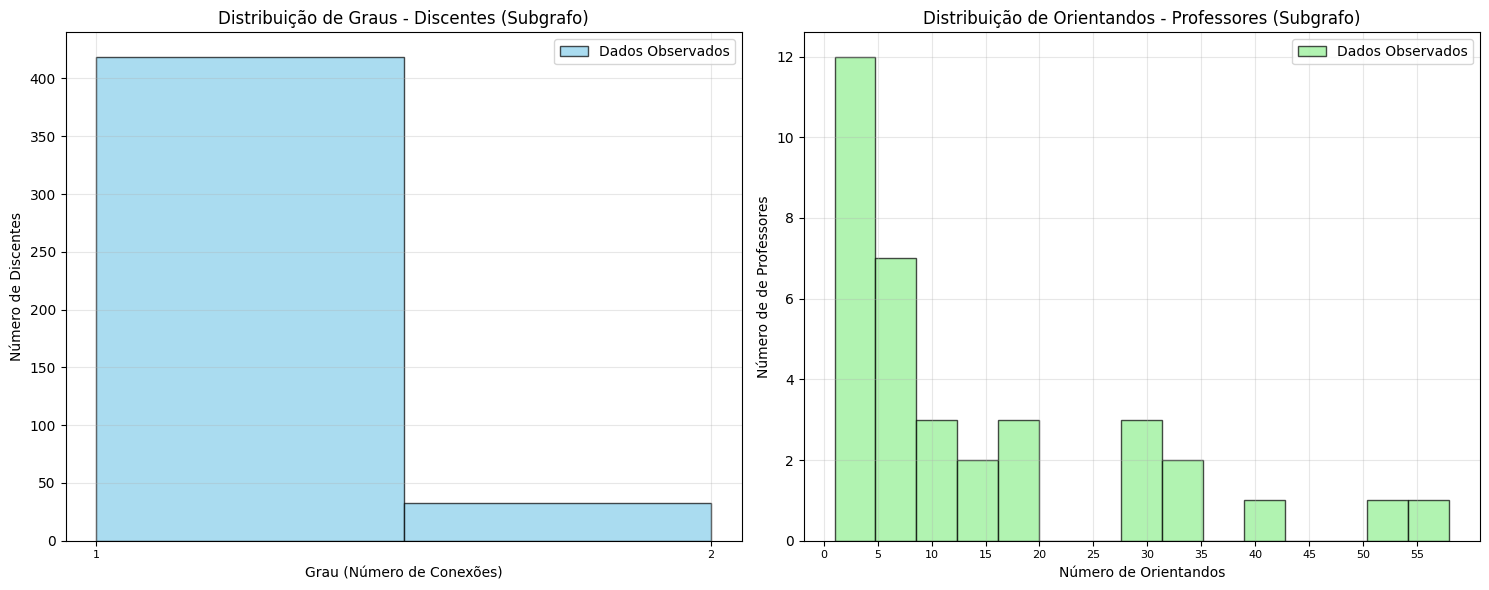

In [34]:
import collections

# Calcular o número de discentes por orientador para o gráfico de barras
discentes_por_orientador = {}
# Certifique-se de iterar sobre os nós do subgrafo que são orientadores
orientadores_no_subgrafo = [node for node, data in subgrafo_departamento.nodes(data=True) if data.get('bipartite') == 'orientador']

for orientador in orientadores_no_subgrafo:
    # Contar discentes conectados a este orientador no subgrafo
    count = 0
    for neighbor in subgrafo_departamento.neighbors(orientador):
        if subgrafo_departamento.nodes[neighbor].get('bipartite') == 'discente':
            count += 1
    discentes_por_orientador[orientador] = count

# Preparar dados para o gráfico de barras
orientadores_ids = list(discentes_por_orientador.keys())
numero_discentes = list(discentes_por_orientador.values())

# Ordenar os orientadores pelo número de discentes para uma melhor visualização no gráfico de barras
orientadores_ordenados, discentes_ordenados = zip(*sorted(zip(orientadores_ids, numero_discentes), key=lambda x: x[1], reverse=True))

# Remover o prefixo 'orientador_' dos IDs para exibição no gráfico
orientadores_labels = [oid.replace('orientador_', '') for oid in orientadores_ordenados]


# Criar o gráfico de barras (Orientadores x Discentes)
plt.figure(figsize=(12, 6)) # Aumentar o tamanho para acomodar mais barras
plt.bar(range(len(orientadores_ordenados)), discentes_ordenados, alpha=0.7)
plt.xlabel("Orientador (ID)")
plt.ylabel("Número de Discentes")
plt.title("Número de Discentes por Orientador no Subgrafo")
plt.xticks(range(len(orientadores_ordenados)), orientadores_labels, rotation=90, fontsize=8) # Rotacionar rótulos do eixo x e diminuir fonte
plt.tight_layout() # Ajustar layout para evitar sobreposição de rótulos
plt.grid(axis='y', alpha=0.5)
plt.show()

# Print de espaçamento
print()

# Análise de Distribuição Normal - Discentes e Professores do Subgrafo
import numpy as np
from scipy import stats

# Análise 1: Distribuição Normal para Discentes (grau de conexão) no subgrafo
# Calcular graus apenas dos discentes no subgrafo
graus_discentes_subgrafo = [subgrafo_departamento.degree(node) for node, data in subgrafo_departamento.nodes(data=True)
                           if data.get('bipartite') == 'discente']

# Estatísticas dos discentes no subgrafo
if graus_discentes_subgrafo:
    media_discentes_subgrafo = np.mean(graus_discentes_subgrafo)
    desvio_discentes_subgrafo = np.std(graus_discentes_subgrafo)

    print(f"=== ANÁLISE DE DISTRIBUIÇÃO - DISCENTES (SUBGRAFO) ===")
    print(f"Total de Discentes: {len(graus_discentes_subgrafo)}")
    print(f"Grau médio dos discentes: {media_discentes_subgrafo:.2f}")
    print(f"Grau mínimo: {min(graus_discentes_subgrafo)}")
    print(f"Grau máximo: {max(graus_discentes_subgrafo)}")
    print()

    # Análise 2: Distribuição Normal para Professores (número de orientandos) no subgrafo
    # Usar os dados já calculados de discentes_por_orientador
    orientandos_por_professor_subgrafo = list(discentes_por_orientador.values())

    if orientandos_por_professor_subgrafo:
        # Estatísticas dos professores no subgrafo
        media_professores_subgrafo = np.mean(orientandos_por_professor_subgrafo)
        desvio_professores_subgrafo = np.std(orientandos_por_professor_subgrafo)

        print(f"=== ANÁLISE DE DISTRIBUIÇÃO - PROFESSORES (SUBGRAFO) ===")
        print(f"Total de professores: {len(orientandos_por_professor_subgrafo)}")
        print(f"Número médio de orientandos: {media_professores_subgrafo:.2f}")
        print(f"Mínimo de orientandos: {min(orientandos_por_professor_subgrafo)}")
        print(f"Máximo de orientandos: {max(orientandos_por_professor_subgrafo)}")

        # Visualizações lado a lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Gráfico 1: Histograma - Discentes do Subgrafo
        ax1.hist(graus_discentes_subgrafo, bins=min(15, len(set(graus_discentes_subgrafo))), density=False, alpha=0.7, color='skyblue',
                 edgecolor='black', label='Dados Observados')

        ax1.set_title('Distribuição de Graus - Discentes (Subgrafo)')
        ax1.set_xlabel('Grau (Número de Conexões)')
        ax1.set_ylabel('Número de Discentes')
        ax1.set_xticks(range(int(min(graus_discentes_subgrafo)), int(max(graus_discentes_subgrafo)) + 1, 1))
        ax1.tick_params(axis='x', labelsize=8)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Gráfico 2: Histograma- Professores do Subgrafo
        ax2.hist(orientandos_por_professor_subgrafo, bins=min(15, len(set(orientandos_por_professor_subgrafo))), density=False, alpha=0.7, color='lightgreen',
                 edgecolor='black', label='Dados Observados')

        ax2.set_title('Distribuição de Orientandos - Professores (Subgrafo)')
        ax2.set_xlabel('Número de Orientandos')
        ax2.set_ylabel('Número de de Professores')

        # Ajustar escala do eixo x baseado no range dos dados
        if max(orientandos_por_professor_subgrafo) <= 20:
            ax2.set_xticks(range(int(min(orientandos_por_professor_subgrafo)), int(max(orientandos_por_professor_subgrafo)) + 1, 1))
        else:
            ax2.set_xticks(range(0, int(max(orientandos_por_professor_subgrafo)) + 1, 5))

        ax2.tick_params(axis='x', labelsize=8)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Não há professores suficientes no subgrafo para análise de distribuição.")
else:
    print("Não há discentes suficientes no subgrafo para análise de distribuição.")